In [157]:
import scipy.io as sio
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn import preprocessing
from keras.layers import Layer
from keras import backend as K
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.decomposition import TruncatedSVD
from scipy.stats import gaussian_kde

In [101]:
def nn_time_stepper(model, x_prev):
    x_next = model.predict(x_prev)
    return x_next

def runningMean(mylist, N):
    cumsum, moving_aves, max_vals, min_vals = [0], [], [], []
    vals = []
    for i, x in enumerate(mylist, 1):
        cumsum.append(cumsum[i-1] + x)
        vals.append(x)
        if i>=N:
            max_vals.append(max(vals))
            min_vals.append(min(vals))
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
            vals = []
    return moving_aves, max_vals, min_vals

Instructions for updating:
Use tf.cast instead.
Train Score: 0.58 RMSE
Test Score: 0.29 RMSE


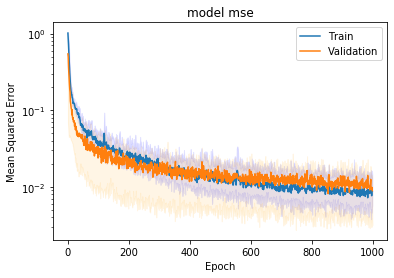

In [26]:
np.random.seed(7)
#Data matrix contains 2 dimensional handel music sample
ks_ = sio.loadmat('kuramoto_sivishinky.mat')#load MATLAB .mat file into python as a dictionary
uu = ks_['uu']#dimension 1024 x 251. 1024 spatial positions, 251 temporal positions

scaler = preprocessing.StandardScaler().fit(uu)#standardize the data
data = scaler.transform(uu)

data_train = data[:,:int(data.shape[1]*0.7)]#data to train model
data_test = data[:,int(data.shape[1]*0.7):]#data to to test the model

#To forecast the values of future time steps of a sequence, specify the responses 
#to be the training sequences with values shifted by one time step. That is, at each 
#time step of the input sequence, the LSTM network learns to predict the value of the next 
#time step. The predictors are the training sequences without the final time step.

m, n = data_train.shape
X = np.transpose(data_train[:, 0:n-2])#all rows starting from first column up to the penultimate
y = np.transpose(data_train[:, 1:n-1])#all rows starting from second column up to the last column

X_test = np.transpose(data_test[:, 0:n-2])#all columns starting from first column up to the penultimate
y_test = np.transpose(data_test[:, 1:n-1])#all columns starting from second column up to the last column

tss = TimeSeriesSplit(n_splits=3)
train_mse = []
val_mse = []
for train_index, test_index in tss.split(X):
    X_train, X_val = X[train_index, :], X[test_index,:]
    y_train, y_val = y[train_index], y[test_index]
      # define model
    model = Sequential()
    model.add(Dense(250, activation='relu',  input_shape = (X_train.shape[1],)))
    model.add(Dense(100, activation='relu')) # New hidden layer with 4 params
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu')) # New hidden layer with 4 params
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu')) # New hidden layer with 4 params
    model.add(Dropout(0.2))
    model.add(Dense(X_train.shape[1]))
    model.compile(optimizer='Adam', loss='mse', metrics=['mean_squared_error'])
    history_train = model.fit(X_train, y_train, epochs=1000, verbose=0)#train the model
    history_validate = model.fit(X_val, y_val, epochs=1000, verbose=0)#validate the model
    train_mse.append(history_train.history['mean_squared_error'])
    val_mse.append(history_validate.history['mean_squared_error'])
    

train_mse_array = np.transpose(np.asarray(train_mse))
val_mse_array = np.transpose(np.asarray(val_mse))
train_av = np.mean(train_mse_array, axis=1)
val_av = np.mean(val_mse_array, axis=1)
train_top = np.amax(train_mse_array, axis=1)
val_top = np.amax(val_mse_array, axis=1)
train_bottom = np.amin(train_mse_array, axis=1)
val_bottom = np.amin(val_mse_array, axis=1)

fig, ax = plt.subplots()
ax.fill_between(range(0,1000), (train_bottom), (train_top), color='blue', alpha=.1)
ax.fill_between(range(0,1000), (val_bottom), (val_top), color='orange', alpha=.1)
ax.plot( train_av, label='Train')
ax.plot(val_av, label='Validation')
ax.set_title('model mse')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Epoch')
ax.set_yscale('log')
ax.legend(loc='best')

# make predictions
trainPredict = model.predict(X)
testPredict = model.predict(X_test)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y[0], trainPredict[0,:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[0,:]))
print('Test Score: %.2f RMSE' % (testScore))

Text(0.5, 0, 'heat')

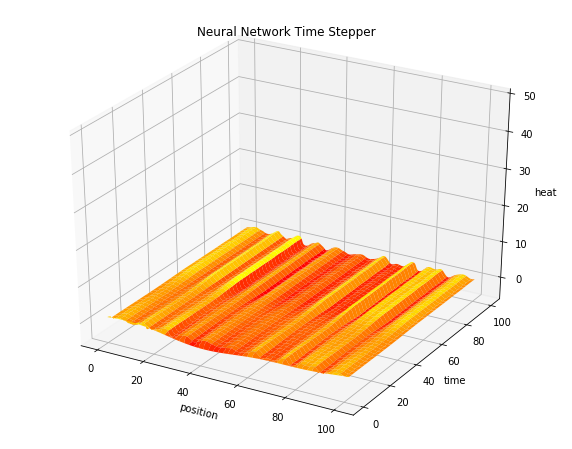

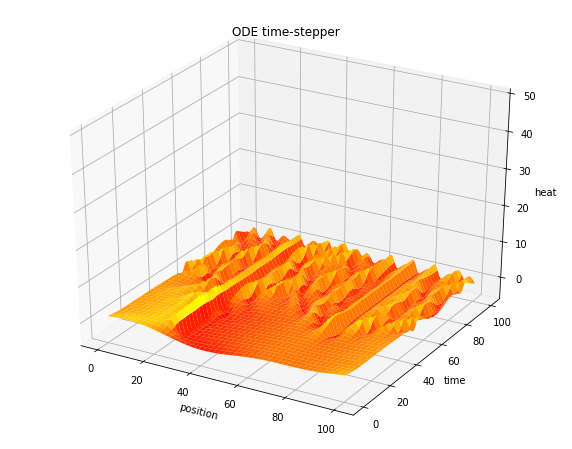

In [307]:
u_0 = np.transpose(data[:,0].reshape(-1, 1))
u = u_0
U = [u]
for i in range(0, ks_['tt'].shape[1] - 1):
    u_next = nn_time_stepper(model, u)
    U.append(u)
    u = u_next

# Make data.
X = ks_['x']
T = ks_['tt']
X, T = np.meshgrid(X, T)
U = scaler.inverse_transform(np.transpose(np.concatenate(U, axis=0)))
U_orig = data

fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection='3d')
# Plot the surface.
surf = ax.plot_surface(np.transpose(X), np.transpose(T), U, cmap=cm.autumn,
                       linewidth=0, antialiased=True)


ax.set_zlim(-5, 50)# Customize the z axis.
ax.set_title("Neural Network Time Stepper")
ax.set_xlabel('position')
ax.set_ylabel('time')
ax.set_zlabel('heat')

fig = plt.figure(figsize=(10, 8))
ax2 = fig.gca(projection='3d')
# Plot the surface.
surf = ax2.plot_surface(np.transpose(X), np.transpose(T), U_orig, cmap=cm.autumn,
                       linewidth=0, antialiased=True)

ax2.set_zlim(-5, 50)# Customize the z axis.
ax2.set_title("ODE time-stepper")
ax2.set_xlabel('position')
ax2.set_ylabel('time')
ax2.set_zlabel('heat')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train Score: 131.88 RMSE
Test Score: 31.78 RMSE


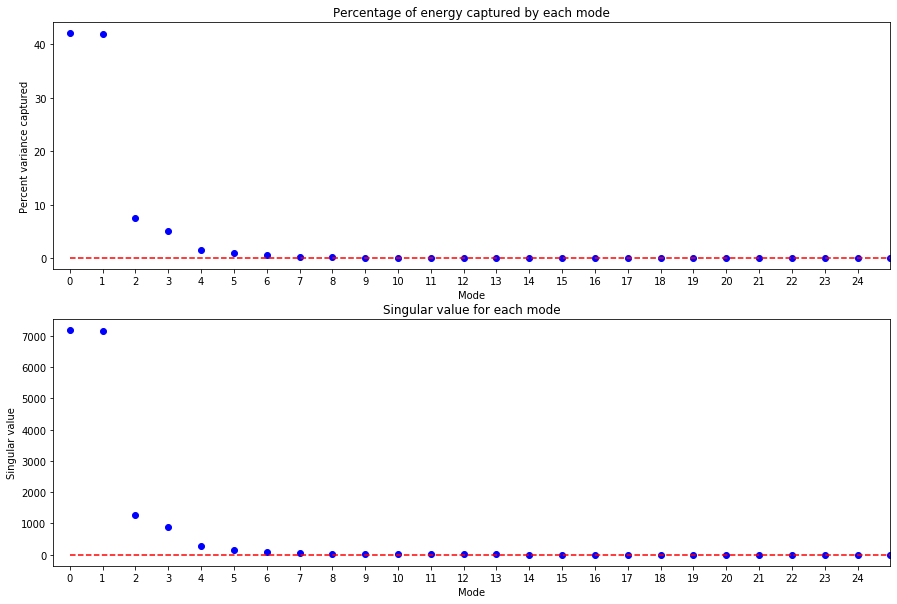

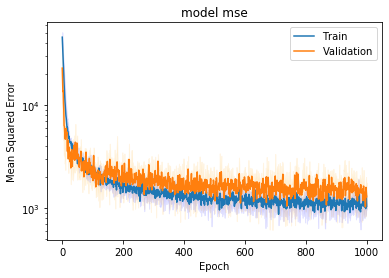

In [4]:
rd_ = sio.loadmat('reaction_diffusion_big.mat')#load MATLAB .mat file into python as a dictionary
u = np.transpose(rd_['u'].reshape(-1, rd_['u'].shape[-1]))#dimension 262144 x 201. 262144 spatial positions, 201 temporal positions
v = np.transpose(rd_['v'].reshape(-1, rd_['v'].shape[-1]))#dimension 262144 x 201. 262144 spatial positions, 201 temporal positions

data_stack = np.hstack((u, v))
scaler_u = preprocessing.StandardScaler()
data = scaler_u.fit_transform(data_stack)

rank = 10
U, Sigma, VT = np.linalg.svd(data, full_matrices=False)
# #u_rr = U_u[:, :rank] @ np.diag(Sigma_u[:rank]) @ VT_u[:rank, :]
# data_lr = U[:, :rank]@data


svd = TruncatedSVD(n_components=rank)# define transform
svd.fit(data)# prepare transform on dataset
data_lr = svd.transform(data)# apply transform to dataset

#Plot percentage of variance captured by differnt modes
#Principle component oscillations
f, [ax1, ax2] = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot((Sigma / sum(Sigma)) * 100, 'bo')
ax1.plot(np.arange(len(Sigma)), np.zeros(len(Sigma)), 'r--')
ax1.set_title('Percentage of energy captured by each mode')
ax1.set_ylabel('Percent variance captured')
ax1.set_xlabel('Mode')
ax1.set_xticks(range(0, 25))
ax1.set_xlim(( -0.5, 25))

ax2.plot(Sigma, 'bo')
ax2.plot(np.arange(len(Sigma)), np.zeros(len(Sigma)), 'r--')
ax2.set_title('Singular value for each mode')
ax2.set_ylabel('Singular value')
ax2.set_xlabel('Mode')
ax2.set_xticks(range(0, 25))
ax2.set_xlim(( -0.5, 25))


data_train = data_lr[:int(data_lr.shape[0]*0.7),:]#data to train model
data_test = data_lr[int(data_lr.shape[0]*0.7):,:]#data to to test the model

#To forecast the values of future time steps of a sequence, specify the responses 
#to be the training sequences with values shifted by one time step. That is, at each 
#time step of the input sequence, the LSTM network learns to predict the value of the next 
#time step. The predictors are the training sequences without the final time step.

n, l = data_train.shape
X = data_train[0:n-2,:]#all cols starting from first column up to the penultimate
y = data_train[1:n-1,:]#all cols starting from second column up to the last column

X_test = data_test[0:n-2,:]#all columns starting from first column up to the penultimate
y_test = data_test[1:n-1,:]#all columns starting from second column up to the last column

tss = TimeSeriesSplit(n_splits=3)
train_mse = []
val_mse = []
for train_index, test_index in tss.split(X):
    X_train, X_val = X[train_index, :], X[test_index, :]
    y_train, y_val = y[train_index, :], y[test_index, :]

    # define model
    model_rd = Sequential()
    model_rd.add(Dense(100, activation='relu',  input_shape = (X_train.shape[1],)))
    model_rd.add(Dense(100, activation='relu')) # New hidden layer with 4 params
    model_rd.add(Dropout(0.2))
    model_rd.add(Dense(75, activation='relu')) # New hidden layer with 4 params
    model_rd.add(Dropout(0.2))
    model_rd.add(Dense(X_train.shape[1]))
    model_rd.compile(optimizer='Adam', loss='mse', metrics=['mean_squared_error'])
    
    history_train = model_rd.fit(X_train, y_train, epochs=1000, verbose=0)#train the model
    history_validate = model_rd.fit(X_val, y_val, epochs=1000, verbose=0)#validate the model
    train_mse.append(history_train.history['mean_squared_error'])
    val_mse.append(history_validate.history['mean_squared_error'])
    

train_mse_array = np.transpose(np.asarray(train_mse))
val_mse_array = np.transpose(np.asarray(val_mse))
train_av = np.mean(train_mse_array, axis=1)
val_av = np.mean(val_mse_array, axis=1)
train_top = np.amax(train_mse_array, axis=1)
val_top = np.amax(val_mse_array, axis=1)
train_bottom = np.amin(train_mse_array, axis=1)
val_bottom = np.amin(val_mse_array, axis=1)

fig, ax = plt.subplots()
ax.fill_between(range(0,1000), (train_bottom), (train_top), color='blue', alpha=.1)
ax.fill_between(range(0,1000), (val_bottom), (val_top), color='orange', alpha=.1)
ax.plot( train_av, label='Train')
ax.plot(val_av, label='Validation')
ax.set_title('model mse')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Epoch')
ax.set_yscale('log')
ax.legend(loc='best')

# make predictions
trainPredict = model_rd.predict(X)
testPredict = model_rd.predict(X_test)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y[0], trainPredict[0,:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[0,:]))
print('Test Score: %.2f RMSE' % (testScore))

Text(0, 0.5, 'Y')

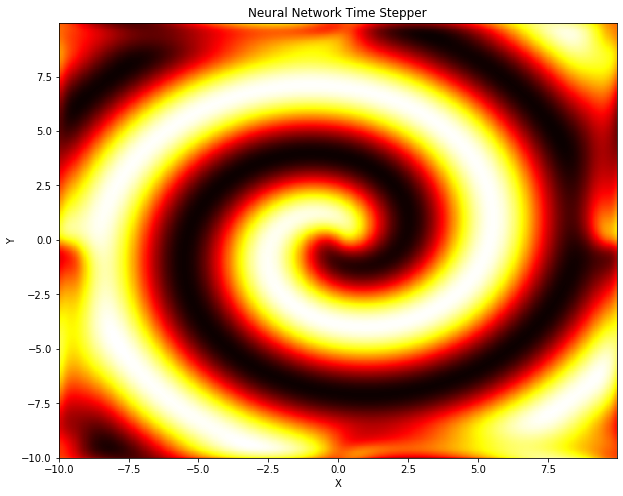

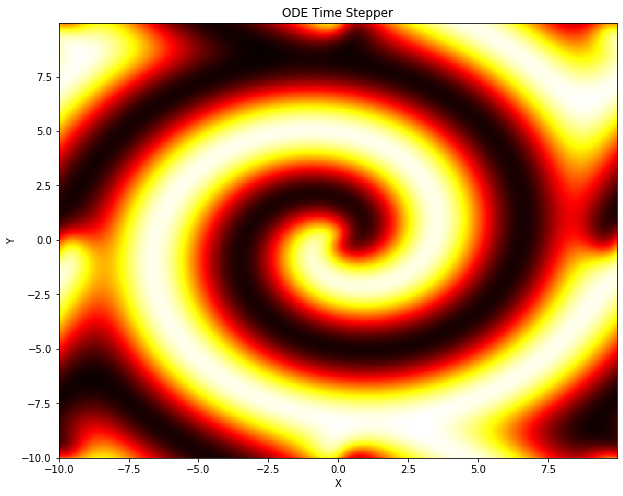

In [16]:
#visualize results (pcolor(x,y,u(:,:,end)))
uv_0 = data_lr[0,:].reshape(1, -1)#initial time step
uv = uv_0
UV = [uv]
for i in range(0, rd_['t'].shape[0] - 1):
    uv_next = nn_time_stepper(model_rd, uv)
    UV.append(uv)
    uv = uv_next

# Make data.
X = rd_['x']
Y = rd_['y']
X, Y = np.meshgrid(X, Y)

UV = scaler_u.inverse_transform(svd.inverse_transform(np.concatenate(UV, axis=0)))
u_out, v_out = np.split(UV, 2, axis=1)
u_out = u_out.reshape(-1, rd_['u'].shape[0], rd_['u'].shape[0])
u_out_new = np.transpose(u_out, (1, 2, 0))
U_orig = rd_['u']

fig, ax1 = plt.subplots(figsize=(10, 8))
# Plot the surface.
ax1.pcolor(X, Y, u_out_new[:,:,-1], cmap=cm.hot)


#ax.set_zlim(-5, 50)# Customize the z axis.
ax1.set_title("Neural Network Time Stepper")
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

fig, ax2 = plt.subplots(figsize=(10, 8))
# Plot the surface.
ax2.pcolor(X, Y, U_orig[:,:,-1], cmap=cm.hot)

#ax.set_zlim(-5, 50)# Customize the z axis.
ax2.set_title("ODE Time Stepper")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

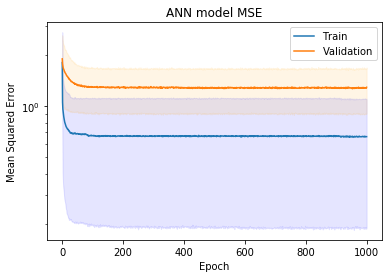

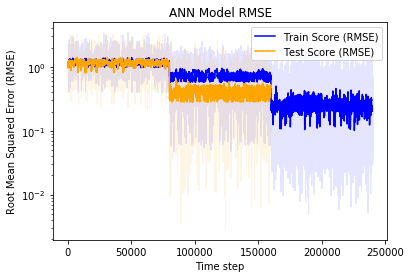

In [37]:
lor_train = sio.loadmat('lorentz_train.mat')#load MATLAB .mat file into python as a dictionary
lor_test = sio.loadmat('lorentz_test.mat')#load MATLAB .mat file into python as a dictionary
in_train, out_train, x0, t =  lor_train['input'], lor_train['output'], lor_train['x0'], lor_train['t']
in_test, out_test = lor_test['input'], lor_test['output']

X = in_train#all cols starting from first column up to the penultimate
y = out_train#all cols starting from second column up to the last column

X_test = in_test#all columns starting from first column up to the penultimate
y_test = out_test#all columns starting from second column up to the last column

tss = TimeSeriesSplit(n_splits=3)
train_mse = []
val_mse = []
for train_index, test_index in tss.split(X):
    X_train, X_val = X[train_index, :], X[test_index, :]
    y_train, y_val = y[train_index, :], y[test_index, :]

    # define model
    model_lor = Sequential()
    model_lor.add(Dense(100, activation='relu',  input_shape = (X_train.shape[1],)))
    model_lor.add(Dense(100, activation='relu')) # New hidden layer with 4 params
    model_lor.add(Dropout(0.2))
    model_lor.add(Dense(X_train.shape[1]))
    model_lor.compile(optimizer='Adam', loss='mse', metrics=['mean_squared_error'])
    
    history_train = model_lor.fit(X_train, y_train, epochs=1000, verbose=0)#train the model
    history_validate = model_lor.fit(X_val, y_val, epochs=1000, verbose=0)#validate the model
    train_mse.append(history_train.history['mean_squared_error'])
    val_mse.append(history_validate.history['mean_squared_error'])
    

train_mse_array = np.transpose(np.asarray(train_mse))
val_mse_array = np.transpose(np.asarray(val_mse))
train_av = np.mean(train_mse_array, axis=1)
val_av = np.mean(val_mse_array, axis=1)
train_top = np.amax(train_mse_array, axis=1)
val_top = np.amax(val_mse_array, axis=1)
train_bottom = np.amin(train_mse_array, axis=1)
val_bottom = np.amin(val_mse_array, axis=1)

fig, ax = plt.subplots()
ax.fill_between(range(0,1000), (train_bottom), (train_top), color='blue', alpha=.1)
ax.fill_between(range(0,1000), (val_bottom), (val_top), color='orange', alpha=.1)
ax.plot(train_av, label='Train')
ax.plot(val_av, label='Validation')
ax.set_title('ANN model MSE')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Epoch')
ax.set_yscale('log')
ax.legend(loc='best')

# make predictions
trainPredict = model_lor.predict(X)
testPredict = model_lor.predict(X_test)

# calculate root mean squared error
trainScore = []
testScore = []
for i in range(len(y)):
    train_error = math.sqrt(mean_squared_error(y[i], trainPredict[i,:]))
    trainScore.append(train_error)
for i in range(len(y_test)):
    test_error = math.sqrt(mean_squared_error(y_test[i], testPredict[i,:]))
    testScore.append(test_error)

train_RMSE_running_mean, train_maxs, train_mins = runningMean(trainScore, 200)
test_RMSE_running_mean, test_maxs, test_mins = runningMean(testScore, 200)


fig, ax = plt.subplots()
ax.fill_between(range(len(train_RMSE_running_mean)), (train_mins), (train_maxs), color='blue', alpha=.1)
ax.fill_between(range(len(test_RMSE_running_mean)), (test_mins), (test_maxs), color='orange', alpha=.1)
ax.plot(train_RMSE_running_mean, color='blue', label='Train Score (RMSE)')
ax.plot(test_RMSE_running_mean, color='orange', label='Test Score (RMSE)')
ax.set_title('ANN Model RMSE')
ax.set_ylabel('Root Mean Squared Error (RMSE)')
ax.set_xlabel('Time step')
ax.set_yscale('log')
ax.legend(loc='best')

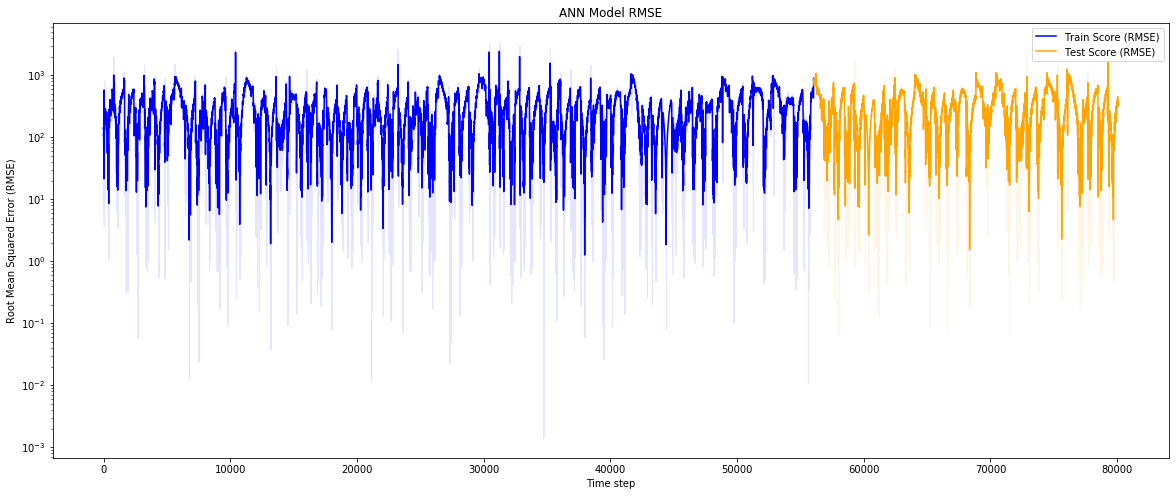

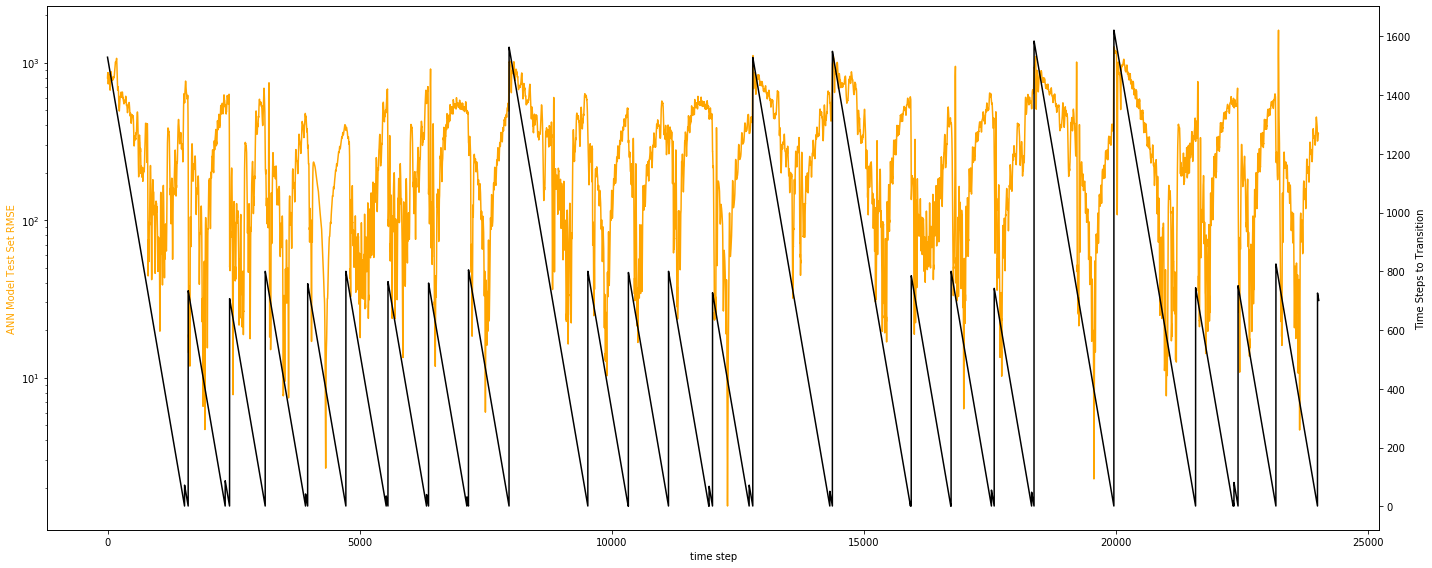

In [160]:
# treat it as a regression problem too, predict the # of time steps 
# until the next transition

lor_p28 = sio.loadmat('lorentz_p28.mat')#load MATLAB .mat file into python as a dictionary
data, x0, t =  lor_p28['data'], lor_p28['x0'], lor_p28['t']
x_vals = data[:,0]#get x position values
lobe_indicator = np.sign(x_vals)#get sign of x coordinate (proxy for lobe of lorenz attractor)
t_spots = []#list to hold where transitions occur
for i in range(1, len(lobe_indicator)):
    if lobe_indicator[i - 1] != lobe_indicator[i]:#check if sign has changed on x coordinate (i.e. lobe change)
        t_spots.append(1)#if sign changed, the lobe changed, mark this with 1
    else:
        t_spots.append(0)#otherwise no change, mark with 0

t_spots = np.array(t_spots)#where transistions have occured

transition_indices = np.where(t_spots_in == 1)[0]
steps_to_t = []
j = 0
for i in range(len(t_spots)):
    if j == len(transition_indices) - 1:
        break
    if i == transition_indices[j]:
        j = j + 1
    next_transition = transition_indices[j]
    steps_to_t.append(next_transition - i)

scaler = preprocessing.StandardScaler().fit(data)#standardize the data
data_scaled = scaler.transform(data)

data_train = data_scaled[:int(data.shape[0]*0.7),:]#data to train model
data_test = data_scaled[int(data.shape[0]*0.7):,:]#data to to test the model

X = data_train#all cols starting from first column up to the penultimate
y = np.expand_dims(np.array(steps_to_t[:int(data.shape[0]*0.7)]),  axis=1)#all cols starting from second column up to the last column

X_test = data_test#all columns starting from first column up to the penultimate
y_test = np.expand_dims(np.array(steps_to_t[int(data.shape[0]*0.7):]), axis=1)#all columns starting from second column up to the last column

tss = TimeSeriesSplit(n_splits=3)
train_mse = []
val_mse = []
for train_index, test_index in tss.split(X):
    X_train, X_val = X[train_index, :], X[test_index, :]
    y_train, y_val = y[train_index], y[test_index]

    # define model
    model_lorp28 = Sequential()
    model_lorp28.add(Dense(10, activation='relu',  input_shape = (X_train.shape[1],)))
    model_lorp28.add(Dense(10, activation='relu')) # New hidden layer with 4 params
    model_lorp28.add(Dropout(0.2))
    model_lorp28.add(Dense(10, activation='relu')) # New hidden layer with 4 params
    model_lorp28.add(Dropout(0.2))
    model_lorp28.add(Dense(1))
    model_lorp28.compile(optimizer='Adam', loss='mse', metrics=['mean_squared_error'])
    
    history_train = model_lorp28.fit(X_train, y_train, epochs=1000, verbose=0)#train the model
    history_validate = model_lorp28.fit(X_val, y_val, epochs=1000, verbose=0)#validate the model
    train_mse.append(history_train.history['mean_squared_error'])
    val_mse.append(history_validate.history['mean_squared_error'])
    

train_mse_array = np.transpose(np.asarray(train_mse))
val_mse_array = np.transpose(np.asarray(val_mse))
train_av = np.mean(train_mse_array, axis=1)
val_av = np.mean(val_mse_array, axis=1)
train_top = np.amax(train_mse_array, axis=1)
val_top = np.amax(val_mse_array, axis=1)
train_bottom = np.amin(train_mse_array, axis=1)
val_bottom = np.amin(val_mse_array, axis=1)

fig, ax = plt.subplots(figsize = (20, 8))
ax.fill_between(range(0,1000), (train_bottom), (train_top), color='blue', alpha=.1)
ax.fill_between(range(0,1000), (val_bottom), (val_top), color='orange', alpha=.1)
ax.plot(train_av, label='Train')
ax.plot(val_av, label='Validation')
ax.set_title('ANN model MSE')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Epoch')
ax.set_yscale('log')
ax.legend(loc='best')

# make predictions
trainPredict = model_lor.predict(X)
testPredict = model_lor.predict(X_test)

# calculate root mean squared error
trainScore = []
testScore = []
for i in range(len(y)):
    train_error = math.sqrt(mean_squared_error(y[i], trainPredict[i,:]))
    trainScore.append(train_error)
for i in range(len(y_test)):
    test_error = math.sqrt(mean_squared_error(y_test[i], testPredict[i,:]))
    testScore.append(test_error)


train_RMSE_running_mean, train_maxs, train_mins = runningMean(trainScore, 10)
test_RMSE_running_mean, test_maxs, test_mins = runningMean(testScore, 10)


fig, ax = plt.subplots(figsize = (20, 8))
ax.fill_between(range(len(train_RMSE_running_mean)), (train_mins), (train_maxs), color='blue', alpha=.1)
ax.fill_between(np.arange(len(train_RMSE_running_mean), len(train_RMSE_running_mean) + len(test_RMSE_running_mean)), (test_mins), (test_maxs), color='orange', alpha=.1)
ax.plot(train_RMSE_running_mean, color='blue', label='Train Score (RMSE)')
ax.plot(np.arange(len(train_RMSE_running_mean), len(train_RMSE_running_mean) + len(test_RMSE_running_mean)),test_RMSE_running_mean, color='orange', label='Test Score (RMSE)')
ax.set_title('ANN Model RMSE')
ax.set_ylabel('Root Mean Squared Error (RMSE)')
ax.set_xlabel('Time step')
ax.set_yscale('log')
ax.legend(loc='best')


fig, ax1 = plt.subplots(figsize = (20, 8))
ax1.set_xlabel('time step')
ax1.set_ylabel('ANN Model Test Set RMSE', color='orange')
ax1.plot(range(len(test_RMSE_running_mean)), test_RMSE_running_mean, color='orange', label='Test Score (RMSE)')
ax1.set_yscale('log')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Time Steps to Transition', color='black')  # we already handled the x-label with ax1
ax2.plot(range(len(y_test)), y_test, color='black')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

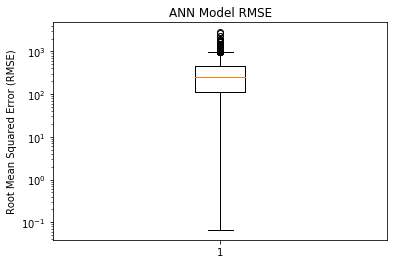

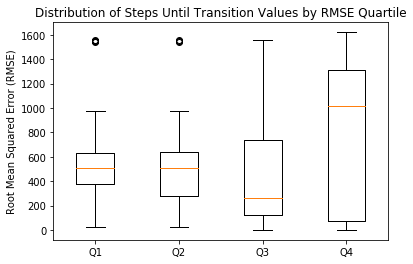

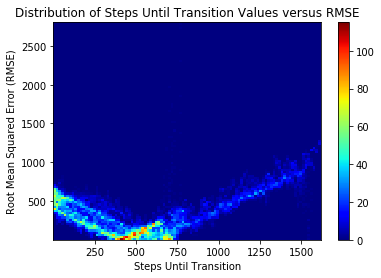

In [195]:
fig, ax = plt.subplots()
ax.boxplot(testScore)
ax.set_title('ANN Model RMSE')
ax.set_ylabel('Root Mean Squared Error (RMSE)')
ax.set_yscale('log')

#testScore = np.flatten(np.array(testScore), axis=1)

q1 = np.quantile(testScore, 0.25)#get lower quartile threshold of test RMSE values
q2 = np.quantile(testScore, 0.5)#get lower quartile threshold of test RMSE values
q3 = np.quantile(testScore, 0.75)#get lower quartile threshold of test RMSE values
q4 = max(testScore)#get lower quartile threshold of test RMSE values

q1_inds = np.where(testScore < lq)#get indices where the RMSE is lower than the lower quartile threshold
q2_inds = np.where((testScore < q2) & (testScore > q1))#get indices where the RMSE is in the second quartile threshold
q3_inds = np.where((testScore < q3) & (testScore > q2))#get indices where the RMSE is lower than the lower quartile threshold
q4_inds = np.where((testScore < q4) & (testScore > q3))#get indices where the RMSE is lower than the lower quartile threshold

q1_steps = y_test[q1_inds]
q2_steps = y_test[q2_inds]
q3_steps = y_test[q3_inds]
q4_steps = y_test[q4_inds]

my_dict = {'Q1': q1_steps, 'Q2': q2_steps,'Q3': q3_steps, 'Q4':q4_steps}

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_title('Distribution of Steps Until Transition Values by RMSE Quartile')
ax.set_ylabel('Root Mean Squared Error (RMSE)')
ax.set_xticklabels(my_dict.keys())

fig, ax = plt.subplots()
counts, xedges, yedges, im = ax.hist2d(y_test, testScore, bins = 100, cmap=plt.cm.jet)
ax.set_title('Distribution of Steps Until Transition Values versus RMSE')
ax.set_ylabel('Root Mean Squared Error (RMSE)')
ax.set_xlabel('Steps Until Transition')
fig.colorbar(im, ax=ax)